<a href="https://colab.research.google.com/github/Minh-A/Bitcoin_fluctuation_prediction/blob/main/Fluctuation_Prediction_Beta1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 설명
* https://blog.naver.com/jeonghj66/222008532124
* https://blog.naver.com/naiy0404/222230337030


In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

# 데이터 전처리

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bnk/데이터/final_data_mod.csv', encoding='cp949')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 78 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1202 non-null   object 
 1   Up/Down                  1202 non-null   object 
 2   원/달러(저가)                 1202 non-null   float64
 3   원/달러(종가)                 1202 non-null   float64
 4    open _x                 1202 non-null   int64  
 5    high _x                 1202 non-null   int64  
 6    low _x                  1202 non-null   int64  
 7    close _x                1202 non-null   int64  
 8   전일대비                     1202 non-null   int64  
 9   증감률                      1202 non-null   float64
 10   volume _x               1202 non-null   int64  
 11   value                   1202 non-null   float64
 12  MA(5)                    1202 non-null   int64  
 13  WMA(5)                   1202 non-null   int64  
 14  중심선                     

In [ ]:
data.head()

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,전일대비.1,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,low,close,volume,소비자물가지수,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,-1359000,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,8400.00,9014.23,38171.97003,247.87,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,-660000,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,7540.00,8787.52,52039.26808,247.87,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,8115.48,9240.00,23700.98509,247.87,1,1.34,NaN,NaN,NaN,NaN,NaN,NaN,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10
3,2018-02-04,Down,1070.7,1079.7,9524000,10158000,8765000,8900000,-620000,-0.0651,18781,1.780000e+11,9865800,9491933,11299300,14522983,8.075617e+06,0.13,0.57,-620000,0,620000,195333.3333,760333.3333,0.256905,20.439484,11495016,13935244,-2440228,-2136697,26.289926,29.057600,9199.96,9368.00,7930.00,8184.81,32014,1080,8839595,9227.80,9350.00,7859.00,8167.91,24062.18196,247.87,1,1.34,NaN,NaN,NaN,NaN,NaN,NaN,-1.121999,7571.180807,1.085739,1.693366,59.564491,-0.495010,1653.312875,1625.669332,5.134512,3.639219,681863.9489,5605143266,681863.9489,5605143266,144085.2127,1.184427e+09,24,632632.5583,5200445235,681863.9489,5605143266,1394810.224,11465793353,2076674.173,1.707094e+10
4,2018-02-05,Down,1087.6,1088.5,8900000,9250000,7715000,7832000,-1068000,-0.1200,20710,1.760000e+11,9146400,8814000,10794900,14426556,7.163244e+06,0.09,0.67,-1068000,0,1068000,281000.0000,804285.7143,0.349378,25.891799,10931475,13483151,-2551677,-2219693,3.099338,20.784003,8179.99,8382.80,6625.00,6939.99,63403,1089,7557649,8167.90,8349.16,6425.75,6905.19,59578.69822,247.87,1,1.34,53.121239,10.96,11.12,9.60,10.05,10.05,-1.508322,7285.703698,0.951111,1.577575,50.401685,-0.850115,174.774570,126.968730,0.693550,3.528467,701178.4092

선형 보간법

In [ ]:
# 선형 보간법으로 결측치를 없앰
data1 = data.interpolate(method="linear")

In [ ]:
data1.head(3)

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,전일대비.1,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,low,close,volume,소비자물가지수,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,-1359000,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,8400.00,9014.23,38171.97003,247.87,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,-660000,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,7540.00,8787.52,52039.26808,247.87,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,8115.48,9240.00,23700.98509,247.87,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10


데이터 셋 분류

In [ ]:
# 훈련데이터 셋과 테스트데이터 셋을 분류
train = data1.iloc[:-37,:]
test = data1.iloc[-37:,:]

In [ ]:
# 각 데이터 셋에서 Feature와 label을 분류
train_feature = train.iloc[:,2:]
train_label = train.iloc[:,1]

test_feature = test.iloc[:,2:]
test_label = test.iloc[:,1]

원핫인코딩 처리

In [ ]:
# label은 원핫인코딩 처리
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

In [ ]:
test_label.head(5)

,Down,Up
1165,0,1
1166,1,0
1167,0,1
1168,1,0
1169,1,0


데이터 정규화를 사용

In [ ]:
# 데이터 정규화 (MinMax정규화)
from sklearn.preprocessing import MinMaxScaler

# 훈련 데이터셋 feature
scaler = MinMaxScaler()

train_feature = scaler.fit_transform(train_feature)
train_feature = pd.DataFrame(train_feature)

# 테스트 데이터셋 feature
scaler = MinMaxScaler()

test_feature = scaler.fit_transform(test_feature)
test_feature = pd.DataFrame(test_feature)

train_feature.head(3), test_feature.head(3)

(         0         1         2   ...        73        74        75
 0  0.069712  0.076458  0.104045  ...  0.108162  0.000000  0.070825
 1  0.080288  0.110151  0.085709  ...  0.102847  0.024863  0.067880
 2  0.080288  0.110151  0.077046  ...  0.107617  0.021185  0.071440
 
 [3 rows x 76 columns],
          0         1         2   ...        73        74        75
 0  0.349558  0.488722  0.904467  ...  0.834773  0.109076  0.795455
 1  0.663717  0.627820  0.917638  ...  0.831249  0.128685  0.795455
 2  0.823009  0.665414  0.889173  ...  1.000000  0.167471  1.000000
 
 [3 rows x 76 columns])

슬라이딩 윈도우 형태로 데이터를 변환

In [ ]:
# (배치 사이즈, 날짜, 속성)으로 데이터 셋을 생성
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
# 데이터 셋을 슬라이딩 윈도우 형식으로 만들기

# 훈련데이터 셋
train_feature1, train_label1 = make_dataset(train_feature, train_label, 7)

#테스트 데이터 셋
test_feature, test_label = make_dataset(test_feature, test_label, 7)

# Validation 셋을 추가함
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature1, train_label1, test_size=0.2, shuffle=False)

x_train.shape, x_valid.shape, test_feature.shape, test_label.shape

((926, 7, 76), (232, 7, 76), (30, 7, 76), (30, 2))

# 모델링

## LSTM

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()

model.add(LSTM(76, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh'))


model.add(Dense(2, activation='softmax'))

In [ ]:
# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 76)                46512     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 154       
Total params: 46,666
Trainable params: 46,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=7, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
133/133 [==============================] - 3s 9ms/step - loss: 0.7043 - accuracy: 0.4638 - val_loss: 0.7082 - val_accuracy: 0.4871
Epoch 2/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6938 - accuracy: 0.5227 - val_loss: 0.6952 - val_accuracy: 0.5216
Epoch 3/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6860 - accuracy: 0.5592 - val_loss: 0.7008 - val_accuracy: 0.5129
Epoch 4/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6930 - accuracy: 0.5099 - val_loss: 0.6950 - val_accuracy: 0.5259
Epoch 5/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6903 - accuracy: 0.5152 - val_loss: 0.7232 - val_accuracy: 0.4828
Epoch 6/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6853 - accuracy: 0.5477 - val_loss: 0.7169 - val_accuracy: 0.4741
Epoch 7/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6846 - accuracy: 0.5536 - val_loss: 0.7357 - val_accuracy: 0.4741
Epoch 

8/8 [==============================] - 0s 3ms/step - loss: 0.7588 - accuracy: 0.4655

 정확도 : 0.7588


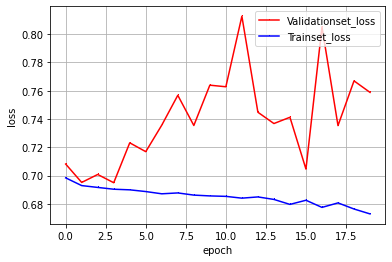

In [ ]:
print("\n 정확도 : %.4f" % (model.evaluate(x_valid, y_valid)[0]))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot (x_len, y_test_loss, marker=',', c='red', label='Validationset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

모델 예측

In [ ]:
# 모델 예측
pred = model.predict(test_feature)
pred

array([[0.79176474, 0.20823525],
       [0.7590498 , 0.24095026],
       [0.68985176, 0.31014824],
       [0.77431196, 0.22568803],
       [0.66593844, 0.33406162],
       [0.494358  , 0.505642  ],
       [0.8651701 , 0.13482992],
       [0.46097335, 0.5390266 ],
       [0.4694874 , 0.5305126 ],
       [0.874156  , 0.12584397],
       [0.4427182 , 0.5572818 ],
       [0.54094535, 0.45905468],
       [0.64471626, 0.35528374],
       [0.9006563 , 0.09934378],
       [0.5940628 , 0.40593714],
       [0.623608  , 0.37639204],
       [0.8293991 , 0.17060089],
       [0.5108202 , 0.48917982],
       [0.86232686, 0.13767311],
       [0.6774308 , 0.32256916],
       [0.7111846 , 0.28881538],
       [0.8740572 , 0.12594284],
       [0.72820866, 0.2717913 ],
       [0.87973434, 0.12026566],
       [0.78885096, 0.21114899],
       [0.43191576, 0.56808424],
       [0.90535456, 0.09464549],
       [0.50739497, 0.49260503],
       [0.47748378, 0.5225162 ],
       [0.5772928 , 0.42270723]], dtype=flo

예측값을 원핫인코딩으로 전환

In [ ]:
# 위치를 숫자로 반환
preds = np.argmax(pred, axis=1)
preds

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
# 원핫인코딩
preds1 = pd.get_dummies(preds)
preds1

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1
6,1,0
7,0,1
8,0,1
9,1,0


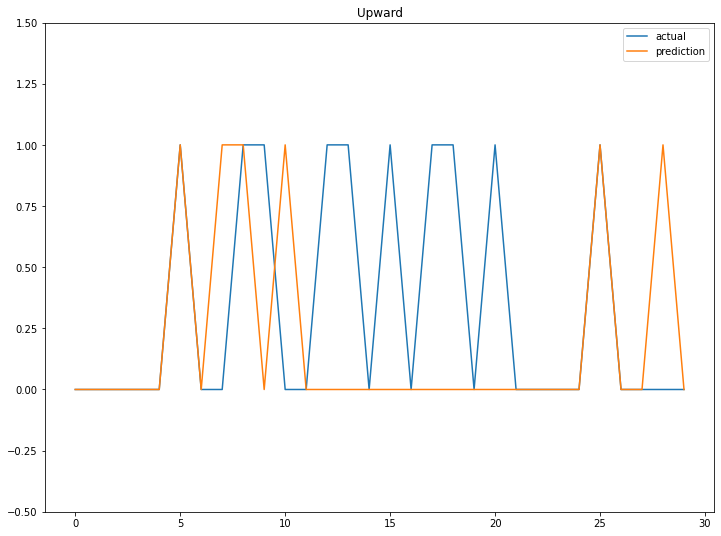

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label[:,1], label = 'actual')
plt.plot(preds1[1], label = 'prediction')
plt.ylim([-0.5, 1.5])
plt.title("Upward") 
plt.legend()
plt.show()

성능지표

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

# 성능지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds))

accuracy 0.6666666666666666
[[17  3]
 [ 7  3]]
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.50      0.30      0.37        10

    accuracy                           0.67        30
   macro avg       0.60      0.57      0.57        30
weighted avg       0.64      0.67      0.64        30



In [ ]:
# 성능평가: 원핫인코딩으로
print(classification_report(test_label, preds1, target_names=['하락', '상승']))

              precision    recall  f1-score   support

          하락       0.71      0.85      0.77        20
          상승       0.50      0.30      0.37        10

   micro avg       0.67      0.67      0.67        30
   macro avg       0.60      0.57      0.57        30
weighted avg       0.64      0.67      0.64        30
 samples avg       0.67      0.67      0.67        30



## RNN

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import SimpleRNN

model = Sequential()

model.add(SimpleRNN(76, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh'))


model.add(Dense(2, activation='softmax'))

In [ ]:
# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 76)                11628     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 154       
Total params: 11,782
Trainable params: 11,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=7, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
133/133 [==============================] - 2s 7ms/step - loss: 0.7212 - accuracy: 0.4703 - val_loss: 0.7862 - val_accuracy: 0.3922
Epoch 2/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5163 - val_loss: 0.7086 - val_accuracy: 0.5474
Epoch 3/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5326 - val_loss: 0.8027 - val_accuracy: 0.3966
Epoch 4/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5241 - val_loss: 0.7786 - val_accuracy: 0.4181
Epoch 5/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5499 - val_loss: 0.7114 - val_accuracy: 0.5302
Epoch 6/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5533 - val_loss: 0.7569 - val_accuracy: 0.4741
Epoch 7/20
133/133 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5480 - val_loss: 0.7948 - val_accuracy: 0.4526
Epoch 

8/8 [==============================] - 0s 3ms/step - loss: 0.7591 - accuracy: 0.4181

 정확도 : 0.7591


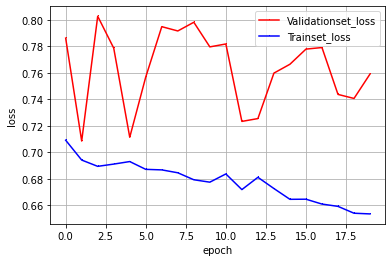

In [ ]:
print("\n 정확도 : %.4f" % (model.evaluate(x_valid, y_valid)[0]))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot (x_len, y_test_loss, marker=',', c='red', label='Validationset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

모델 예측

In [ ]:
# 모델 예측
pred = model.predict(test_feature)
pred

array([[0.7229139 , 0.27708605],
       [0.6914642 , 0.3085358 ],
       [0.27766198, 0.7223381 ],
       [0.91069394, 0.08930599],
       [0.19813235, 0.80186766],
       [0.20572335, 0.7942766 ],
       [0.91539276, 0.08460728],
       [0.26147556, 0.73852444],
       [0.21967192, 0.7803281 ],
       [0.97528064, 0.02471939],
       [0.73382777, 0.26617223],
       [0.8894177 , 0.11058228],
       [0.61127764, 0.3887224 ],
       [0.9412037 , 0.05879626],
       [0.5957559 , 0.40424412],
       [0.59005594, 0.409944  ],
       [0.63669765, 0.36330235],
       [0.1293315 , 0.8706685 ],
       [0.94475156, 0.05524845],
       [0.5374959 , 0.46250418],
       [0.8117555 , 0.1882445 ],
       [0.87596226, 0.12403773],
       [0.6107788 , 0.3892212 ],
       [0.9597427 , 0.04025732],
       [0.6627618 , 0.33723816],
       [0.03680162, 0.96319836],
       [0.95426494, 0.04573507],
       [0.4401045 , 0.5598955 ],
       [0.08354542, 0.9164546 ],
       [0.58181906, 0.418181  ]], dtype=flo

예측값을 원핫인코딩으로 전환

In [ ]:
# 위치를 숫자로 반환
preds = np.argmax(pred, axis=1)
preds

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0])

In [ ]:
# 원핫인코딩
preds1 = pd.get_dummies(preds)
preds1

,0,1
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
5,0,1
6,1,0
7,0,1
8,0,1
9,1,0


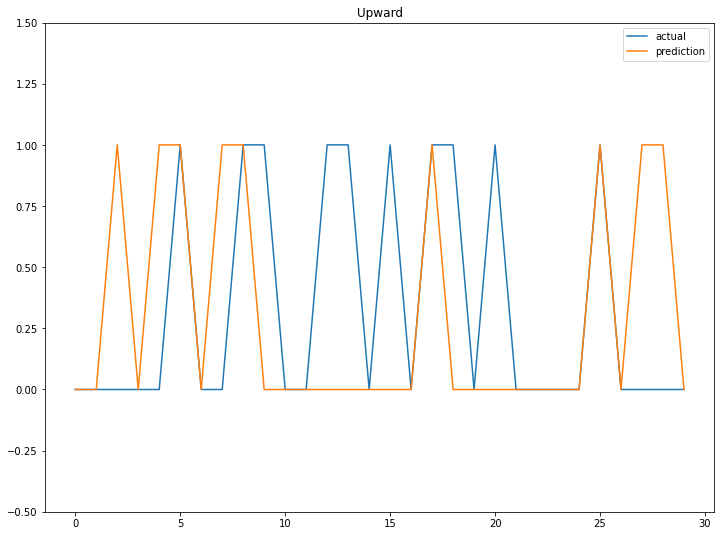

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label[:,1], label = 'actual')
plt.plot(preds1[1], label = 'prediction')
plt.ylim([-0.5, 1.5])
plt.title("Upward") 
plt.legend()
plt.show()

성능지표

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

# 성능지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds))

accuracy 0.6333333333333333
[[15  5]
 [ 6  4]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.44      0.40      0.42        10

    accuracy                           0.63        30
   macro avg       0.58      0.57      0.58        30
weighted avg       0.62      0.63      0.63        30



In [ ]:
# 성능평가: 원핫인코딩으로
print(classification_report(test_label, preds1, target_names=['하락', '상승']))

              precision    recall  f1-score   support

          하락       0.71      0.75      0.73        20
          상승       0.44      0.40      0.42        10

   micro avg       0.63      0.63      0.63        30
   macro avg       0.58      0.57      0.58        30
weighted avg       0.62      0.63      0.63        30
 samples avg       0.63      0.63      0.63        30



## GRU

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GRU

model = Sequential()

model.add(GRU(76, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh'))


model.add(Dense(2, activation='softmax'))

In [ ]:
# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 76)                35112     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 154       
Total params: 35,266
Trainable params: 35,266
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=7, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
133/133 [==============================] - 5s 9ms/step - loss: 0.7083 - accuracy: 0.5048 - val_loss: 0.8054 - val_accuracy: 0.4009
Epoch 2/20
133/133 [==============================] - 1s 6ms/step - loss: 0.6944 - accuracy: 0.5175 - val_loss: 0.9135 - val_accuracy: 0.3879
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 0.6911 - accuracy: 0.5517 - val_loss: 0.7851 - val_accuracy: 0.4871
Epoch 4/20
133/133 [==============================] - 1s 6ms/step - loss: 0.6885 - accuracy: 0.5368 - val_loss: 0.8547 - val_accuracy: 0.3922
Epoch 5/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6902 - accuracy: 0.5180 - val_loss: 0.8196 - val_accuracy: 0.4612
Epoch 6/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6864 - accuracy: 0.5240 - val_loss: 0.8198 - val_accuracy: 0.4440
Epoch 7/20
133/133 [==============================] - 1s 5ms/step - loss: 0.6912 - accuracy: 0.5163 - val_loss: 0.8544 - val_accuracy: 0.4569
Epoch 

8/8 [==============================] - 0s 3ms/step - loss: 0.7388 - accuracy: 0.4828

 정확도 : 0.7388


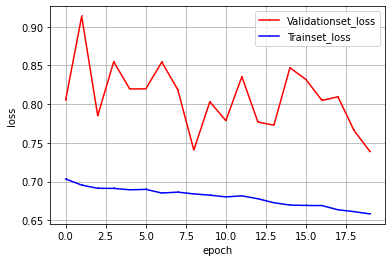

In [ ]:
print("\n 정확도 : %.4f" % (model.evaluate(x_valid, y_valid)[0]))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot (x_len, y_test_loss, marker=',', c='red', label='Validationset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

모델 예측

In [ ]:
# 모델 예측
pred = model.predict(test_feature)
pred

array([[0.7266014 , 0.2733986 ],
       [0.74280536, 0.25719464],
       [0.5474491 , 0.4525509 ],
       [0.8232584 , 0.17674159],
       [0.67128295, 0.32871708],
       [0.28720388, 0.7127961 ],
       [0.96230346, 0.03769651],
       [0.684182  , 0.315818  ],
       [0.1249741 , 0.87502587],
       [0.90134627, 0.09865376],
       [0.88782984, 0.11217017],
       [0.79072785, 0.20927213],
       [0.7290059 , 0.2709941 ],
       [0.9614855 , 0.03851448],
       [0.946259  , 0.05374093],
       [0.72518575, 0.2748142 ],
       [0.7593198 , 0.24068023],
       [0.33459547, 0.6654046 ],
       [0.84373975, 0.15626024],
       [0.7739865 , 0.22601354],
       [0.585868  , 0.414132  ],
       [0.78335714, 0.21664287],
       [0.6608724 , 0.3391276 ],
       [0.9524793 , 0.04752072],
       [0.9070756 , 0.0929244 ],
       [0.28160778, 0.71839225],
       [0.98187894, 0.0181211 ],
       [0.8969449 , 0.1030551 ],
       [0.38446844, 0.61553156],
       [0.6734701 , 0.32652992]], dtype=flo

예측값을 원핫인코딩으로 전환

In [ ]:
# 위치를 숫자로 반환
preds = np.argmax(pred, axis=1)
preds

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
# 원핫인코딩
preds1 = pd.get_dummies(preds)
preds1

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1
6,1,0
7,1,0
8,0,1
9,1,0


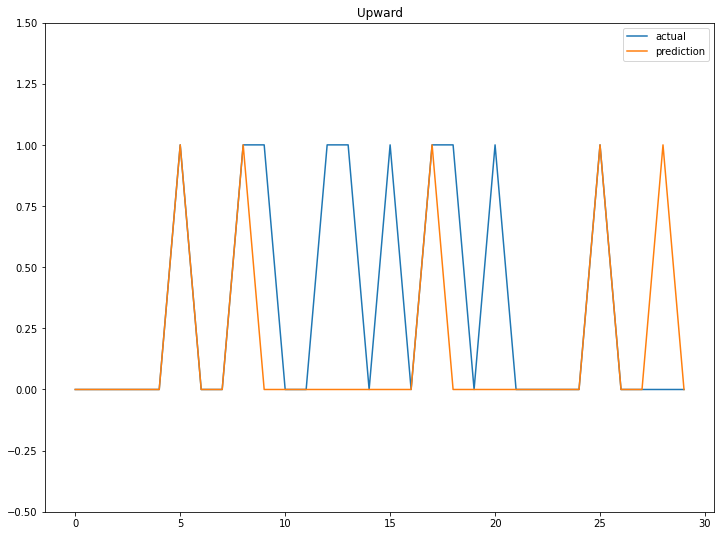

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label[:,1], label = 'actual')
plt.plot(preds1[1], label = 'prediction')
plt.ylim([-0.5, 1.5])
plt.title("Upward") 
plt.legend()
plt.show()

성능지표

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

# 성능지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds))

accuracy 0.7666666666666667
[[19  1]
 [ 6  4]]
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        20
           1       0.80      0.40      0.53        10

    accuracy                           0.77        30
   macro avg       0.78      0.68      0.69        30
weighted avg       0.77      0.77      0.74        30



In [ ]:
# 성능평가: 원핫인코딩으로
print(classification_report(test_label, preds1, target_names=['하락', '상승']))

              precision    recall  f1-score   support

          하락       0.76      0.95      0.84        20
          상승       0.80      0.40      0.53        10

   micro avg       0.77      0.77      0.77        30
   macro avg       0.78      0.68      0.69        30
weighted avg       0.77      0.77      0.74        30
 samples avg       0.77      0.77      0.77        30

